In [344]:
%matplotlib inline
import numpy as np
from skimage import transform as tf
import scipy.ndimage as ndimage

In [751]:
image = np.arange(900).reshape(30,30)

### Slim ROI class

In [984]:
class Roi():
    def __init__(self, image, x, y, size_x, size_y, affine, buffer=0):
        self.image = image
        self.x = x
        self.y = y
        self.size_x = size_x
        self.size_y = size_y
        self.affine = affine
        self.buffer = buffer
        
    @property
    def x(self):
        return self._whole_x + self._remainder_x

    @x.setter
    def x(self, x):
        self._whole_x = floor(x)
        self._remainder_x = x - self._whole_x

    @property
    def y(self):
        return self._whole_y + self._remainder_y

    @y.setter
    def y(self, y):
        self._whole_y = floor(y)
        self._remainder_y = y - self._whole_y

    def clip_coordinate_to_image_coordinate(self, xy):
        transformed = self.subwindow_affine_to_image_coords(xy)
        if len(transformed) == 1:
            return transformed[0]
        else:
            return transformed
    
    def clip(self):
        # Read the data from the array
        min_x = int(self._whole_x - self.size_x - self.buffer)
        min_y = int(self._whole_y - self.size_y - self.buffer)
        x_read_length = (self.size_x * 2) + (self.buffer * 2)
        y_read_length = (self.size_y * 2) + (self.buffer * 2)
        data = self.image[min_y:min_y + y_read_length, min_x:min_x + x_read_length]
        
        # Pixel lock the data to the nearest integer. This handles warping to the nearest whole pixel.
        pixel_locking_affine = tf.SimilarityTransform(translation=(-self._remainder_x,
                                                                   -self._remainder_y))        
        
        center = (np.array(data.shape)-1)[::-1] / 2.  # Where center is a zero based index of the image center
        self.roi_center_to_image_location = tf.SimilarityTransform(translation=(self.x-center[0], self.y-center[1]))
        # This has to incorporate the roi_center_to_image_location transformation
        self.subwindow_affine = pixel_locking_affine + \
                                tf.SimilarityTransform(translation=-center) + \
                                self.affine + \
                                tf.SimilarityTransform(translation=center)  

        # Sanity check - even with rotation and shear, the affine should never move the center of the array.

        # Build the transformation from warped image space back to unwarped image space
        self.subwindow_affine_to_image_coords = self.subwindow_affine.inverse + self.roi_center_to_image_location + pixel_locking_affine

        # Warp the pixel locked data
        warped_data = tf.warp(data,
                              self.subwindow_affine.inverse,
                              order=3,
                              mode='constant',
                              cval=0,
                              preserve_range=True)

        return warped_data

### No rotation, just translation, no pixel locking

In this most basic example, the initial (centered) coordinates of the ROI are integrers and the affine transformation has no rotation or shear. The mapping that the ROI has to track is between the center coordinate of the ROI and the pixel coordinate of the entire image. T

In [985]:
rotation = tf.AffineTransform(rotation=np.radians(0))
rotation.params

array([[ 1., -0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

Expecting: [13. 17.]
Reprojection of a coordinate from transformed space to image space:  [13. 17.]


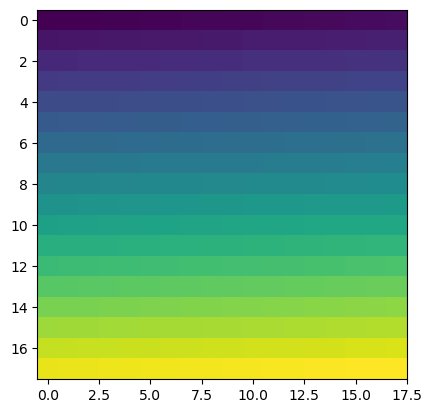

In [986]:
r = Roi(image, 13, 17, 6, 6, rotation, buffer=3)
warped_data = r.clip()
imshow(warped_data)

# The center coordinate in the transformed space must equal the passed x,y coordinates.
print('Expecting: [13. 17.]')
print('Reprojection of a coordinate from transformed space to image space: ', r.clip_coordinate_to_image_coordinate((8.5,8.5)))


### Shift the desired coordinate in the affine space.
In this example the coordinate in the affine space is shifted +1 in the x-direction and -3 in the y-direction. Since the passed affine has no rotation, we expect the result to be the passed x+1 and the passed y-3, or 14,14.

Expecting: [14. 14.]
Reprojection of a coordinate from transformed space to image space:  [14. 14.]


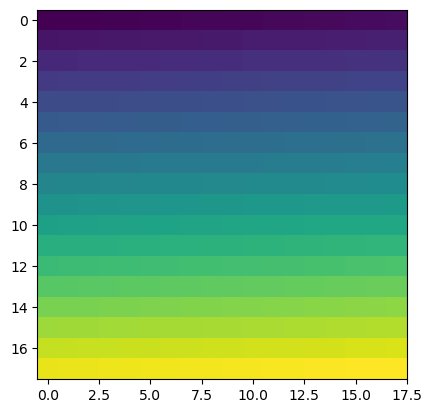

In [987]:
r = Roi(image, 13, 17, 6, 6, rotation, buffer=3)
warped_data = r.clip()
imshow(warped_data)

# The center coordinate in the transformed space must equal the passed x,y coordinates.
print('Expecting: [14. 14.]')
print('Reprojection of a coordinate from transformed space to image space: ', r.clip_coordinate_to_image_coordinate((8.5+1,8.5-3)))

### Add subpixel component
In this example, the input x,y coordinate are no aligned to the pixel edge. The x-coordinate is 0.243 from the pixel read edge and the y coordinate is 0.974 from the pixel read edge. 

The ROI class handles this subpixel adjustment in the warping to pixel lock to an edge (using interpolation). 

As above, the anticipated result of the reprojection from affine space to input image space equals the input x,y.

Expecting: [13.243 17.974]
Reprojection of a coordinate from transformed space to image space:  [13.243 17.974]


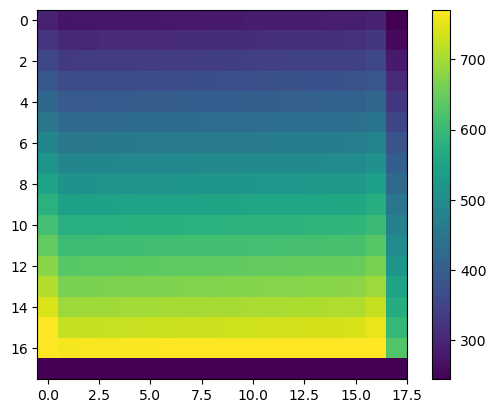

In [988]:
r = Roi(image, 13.243, 17.974, 6, 6, rotation, buffer=3)
warped_data = r.clip()
imshow(warped_data)
colorbar()
# The center coordinate in the transformed space must equal the passed x,y coordinates.
print('Expecting: [13.243 17.974]')
print('Reprojection of a coordinate from transformed space to image space: ', r.clip_coordinate_to_image_coordinate((8.5,8.5)))

### Add a subpixel component and a shift.
This replicates the second example, above, but adds in a x+1 and y-3 shift. The expected results are 14.243 and 14.974.

Expecting: [14.234 14.974]
Reprojection of a coordinate from transformed space to image space:  [14.243 14.974]


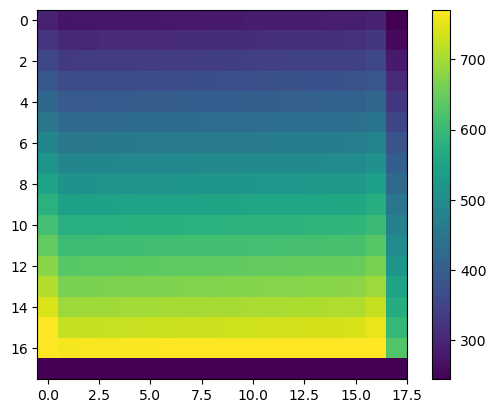

In [989]:
r = Roi(image, 13.243, 17.974, 6, 6, rotation, buffer=3)
warped_data = r.clip()
imshow(warped_data)
colorbar()
# The center coordinate in the transformed space must equal the passed x,y coordinates.
print('Expecting: [14.234 14.974]')
print('Reprojection of a coordinate from transformed space to image space: ', r.clip_coordinate_to_image_coordinate((8.5+1,8.5-3)))

# 45˚ Rotation, whole pixel
In this example, the affine transformation rotates the data clockwise by 30˚. The buffer size (the extra data read to subset the data and ensure that no data values are not being included is adjusted and, therefore, the center is adjusted).

In [990]:
rotation = tf.AffineTransform(rotation=np.radians(-45))
rotation.params

array([[ 0.70710678,  0.70710678,  0.        ],
       [-0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

Reprojection of a coordinate from transformed space to image space:  [13. 17.]


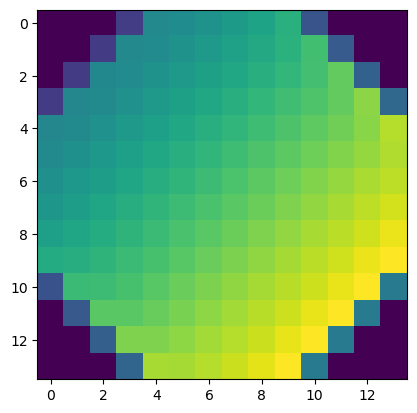

In [991]:
r = Roi(image, 13, 17, 5, 5, rotation, buffer=2)
warped_data = r.clip()
imshow(warped_data)

# The center coordinate in the transformed space must equal the passed x,y coordinates.
print('Reprojection of a coordinate from transformed space to image space: ', r.clip_coordinate_to_image_coordinate((6.5,6.5)))

### 45˚ rotation, subpixel

Reprojection of a coordinate from transformed space to image space:  [13.1 17.7]


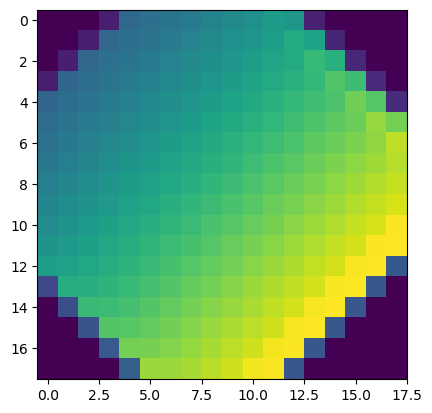

In [992]:
r = Roi(image, 13.1, 17.7, 6, 6, rotation, buffer=3)
warped_data = r.clip()
imshow(warped_data)

# The center coordinate in the transformed space must equal the passed x,y coordinates.
print('Reprojection of a coordinate from transformed space to image space: ', r.clip_coordinate_to_image_coordinate((8.5,8.5)))

###


### 45˚ Rotation, shifted coordinate

Expecting: [13. 19.828]
Reprojection of a coordinate from transformed space to image space:  [13.         19.82842712]


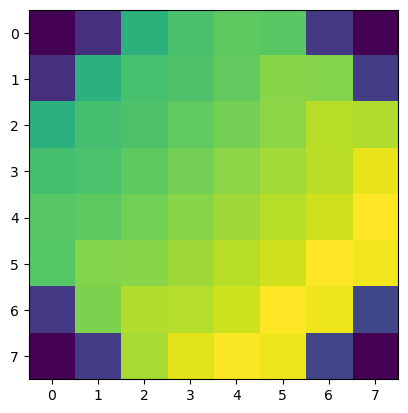

In [995]:
r = Roi(image, 13, 17, 4, 4, rotation, buffer=0)
warped_data = r.clip()
imshow(warped_data)

# The center coordinate in the transformed space must equal the passed x,y coordinates.
print('Expecting: [13. 19.828]')
print('Reprojection of a coordinate from transformed space to image space: ', r.clip_coordinate_to_image_coordinate((3.5+2,3.5+2)))


### 45˚ Rotation, subpixel, shifted coordinate

Expecting: [13.1 20.53]
Reprojection of a coordinate from transformed space to image space:  [13.1        20.52842712]


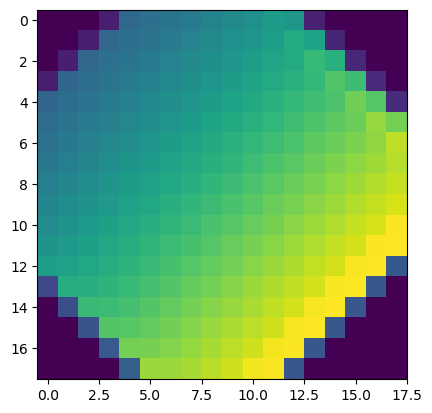

In [994]:
r = Roi(image, 13.1, 17.7, 6, 6, rotation, buffer=3)
warped_data = r.clip()
imshow(warped_data)

# The center coordinate in the transformed space must equal the passed x,y coordinates.
print('Expecting: [13.1 20.53]')
print('Reprojection of a coordinate from transformed space to image space: ', r.clip_coordinate_to_image_coordinate((8.5+2,8.5+2)))

### Manual rotation about a point checking.

In [982]:
# Rotation angle
a = np.radians(-45)

# Point to rotate about
center = 3.5

# point to rotate
x = 5.5
y = 5.5
# center origin on the point to rotate about
xc = x - center
yc = y - center

# Compute the rotation
x1 = xc* np.cos(a) - yc * np.sin(a)
y1 = yc * np.cos(a) + xc*np.sin(a)

# Undo the translation
x1+center, y1+center, x1, y1

(6.32842712474619, 3.5, 2.82842712474619, 2.220446049250313e-16)

In [983]:
# Perform the same operation as above, but use translation matrices
center = np.array([3.5, 3.5])
affine = tf.SimilarityTransform(translation=-center) + \
         rotation + \
         tf.SimilarityTransform(translation=center)

subwindow_coords = affine((x,y))[0]
print(subwindow_coords)

subwindow_affine_to_image_coords = affine.inverse
subwindow_affine_to_image_coords(subwindow_coords)

[6.32842712 3.5       ]


array([[5.5, 5.5]])